In [1]:
from fastai import *
from fastai.tabular import *

import lightgbm as lgb
import xgboost as xgb
import seaborn as sns

from database import db_session
from models import CanaisPorDia

from helper_functions import add_datepart, is_outlier, get_mapa_de_eventos

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
path = Path('data/canais_geral/')
path

PosixPath('data/canais_geral')

In [3]:
db_session.query(CanaisPorDia).count()

15709

In [4]:
rs = db_session.execute('SELECT ADDTIME(data, SEC_TO_TIME(hora*60*60)) AS hora, tempo_medio FROM canais_geral_por_dia')

registros = []
for row in rs:
    registros.append(row)
    
df = pd.DataFrame(registros, columns=['hora', 'tempo_medio'])

In [11]:
rs = db_session.execute('SELECT data, hora, tempo_medio FROM canais_geral_por_dia')

registros = []
for row in rs:
    registros.append(row)
    
df = pd.DataFrame(registros, columns=['data', 'hora', 'tempo_medio'])

In [15]:
df.tail()

,hora,tempo_medio,tipo,5_dia_util,1º dia útil,Ano Novo,Antecede feriado,Antecede feriado prolongado,Arrecadação de Convênios,Arrecadação de DARF e DAS,...,dataDay,dataDayofweek,dataDayofyear,dataIs_month_end,dataIs_month_start,dataIs_quarter_end,dataIs_quarter_start,dataIs_year_end,dataIs_year_start,dataElapsed
15704,19,50.8928,Normal,0,0,0,0,0,0,0,...,23,1,296,False,False,False,False,False,False,1540252800
15705,20,52.5700,Normal,0,0,0,0,0,0,0,...,23,1,296,False,False,False,False,False,False,1540252800
15706,21,49.5197,Normal,0,0,0,0,0,0,0,...,23,1,296,False,False,False,False,False,False,1540252800
15707,22,59.2783,Normal,0,0,0,0,0,0,0,...,23,1,296,False,False,False,False,False,False,1540252800
15708,23,58.2852,Normal,0,0,0,0,0,0,0,...,23,1,296,False,False,False,False,False,False,1540252800


In [7]:
df_mapa = get_mapa_de_eventos()

In [13]:
df.data = df.data.astype(str)
df_mapa.data = df_mapa.data.astype(str)
df = df.merge(df_mapa, on='data', how='left')

In [8]:
# df.loc[df['tempo_medio'] > 200.0]['horaMonth'].value_counts()

In [14]:
# Aplicar função add_datepart para criar features relacionadas
add_datepart(df, 'data', drop=True, time=False)

# Tratar outlayers
df.loc[df['tempo_medio'] > 800.0, 'tempo_medio'] = 800.0

In [9]:
# Aplicar função add_datepart para criar features relacionadas
add_datepart(df, 'hora', drop=True, time=True)

# Tratar outlayers
df.loc[df['tempo_medio'] > 800.0, 'tempo_medio'] = 800.0

In [ ]:
# Criar coluna mean por Dia da Semana / Hora
mean_col = df.groupby(['horaDayofweek', 'horaHour'])['tempo_medio'].mean() # don't reset the index!
df = df.set_index(['horaDayofweek', 'horaHour']) # make the same index here
df['meanDayofweekHour'] = mean_col
df = df.reset_index()

# Criar coluna median por Dia da Semana / Hora
median_col = df.groupby(['horaDayofweek', 'horaHour'])['tempo_medio'].median() # don't reset the index!
df = df.set_index(['horaDayofweek', 'horaHour']) # make the same index here
df['medianDayofweekHour'] = median_col
df = df.reset_index()

In [16]:
# Criar coluna mean por Dia da Semana / Hora
mean_col = df.groupby(['dataDayofweek', 'hora'])['tempo_medio'].mean() # don't reset the index!
df = df.set_index(['dataDayofweek', 'hora']) # make the same index here
df['meanDayofweekHour'] = mean_col
df = df.reset_index()

# Criar coluna median por Dia da Semana / Hora
median_col = df.groupby(['dataDayofweek', 'hora'])['tempo_medio'].median() # don't reset the index!
df = df.set_index(['dataDayofweek', 'hora']) # make the same index here
df['medianDayofweekHour'] = median_col
df = df.reset_index()

In [17]:
df.head()

,dataDayofweek,hora,tempo_medio,tipo,5_dia_util,1º dia útil,Ano Novo,Antecede feriado,Antecede feriado prolongado,Arrecadação de Convênios,...,dataDayofyear,dataIs_month_end,dataIs_month_start,dataIs_quarter_end,dataIs_quarter_start,dataIs_year_end,dataIs_year_start,dataElapsed,meanDayofweekHour,medianDayofweekHour
0,6,0,353.5510,Feriado,0,0,1,0,0,0,...,1,False,True,False,True,False,True,1483228800,96.711609,71.57140
1,6,1,317.1040,Feriado,0,0,1,0,0,0,...,1,False,True,False,True,False,True,1483228800,115.975351,73.19160
2,6,2,423.2300,Feriado,0,0,1,0,0,0,...,1,False,True,False,True,False,True,1483228800,119.638727,82.59330
3,6,3,96.7003,Feriado,0,0,1,0,0,0,...,1,False,True,False,True,False,True,1483228800,74.728029,51.80675
4,6,4,95.6170,Feriado,0,0,1,0,0,0,...,1,False,True,False,True,False,True,1483228800,73.957546,46.33060


In [9]:
# df['rolling_median3'] = df.groupby(['horaDayofweek', 'horaHour'])['tempo_medio'].apply(lambda x: x.rolling(3, min_periods=1, center=True).median())
# df['rolling_median4'] = df.groupby(['horaDayofweek', 'horaHour'])['tempo_medio'].apply(lambda x: x.rolling(4, min_periods=1, center=True).median())
# df['rolling_median5'] = df.groupby(['horaDayofweek', 'horaHour'])['tempo_medio'].apply(lambda x: x.rolling(4, min_periods=1, center=True).median())

In [18]:
_,outlier = is_outlier(df['tempo_medio'], thresh=7.0)

In [ ]:
df[outlier]['horaHour'].value_counts().sort_index().plot(kind='bar')

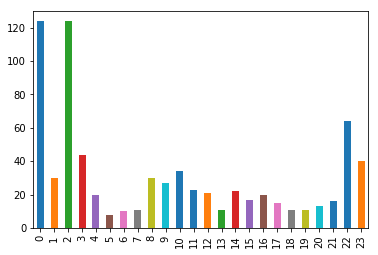

In [20]:
df[outlier]['hora'].value_counts().sort_index().plot(kind='bar')

In [12]:
unique, counts = np.unique(outlier, return_counts=True)
dict(zip(unique, counts))

{False: 14963, True: 746}

In [13]:
df['anomalies'] = df[outlier]['tempo_medio']

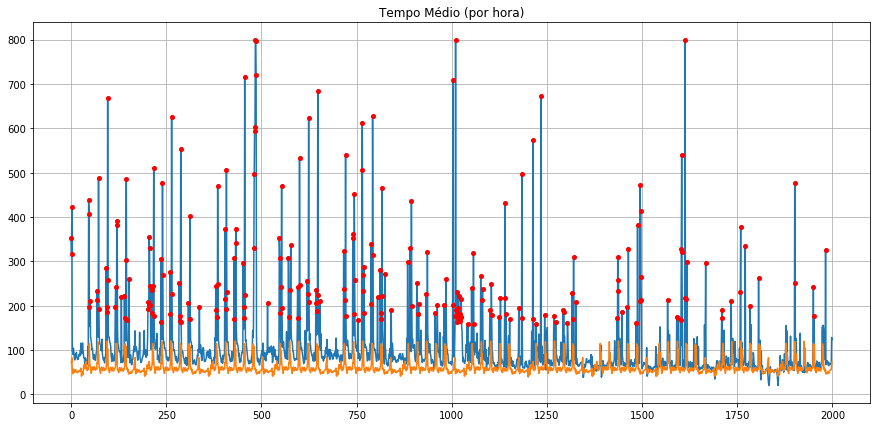

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(df['tempo_medio'][:2000])
plt.plot(df['anomalies'][:2000], "ro", markersize=4)
# plt.plot(df['rolling_median'][:2000])
plt.plot(df['medianDayofweekHour'][:2000])
plt.title('Tempo Médio (por hora)')
plt.grid(True)
plt.show()

In [21]:
# df.set_value(outlier, 'tempo_medio', df[outlier]['medianDayofweekHour'])
df.at[outlier, 'tempo_medio'] = df[outlier]['medianDayofweekHour']

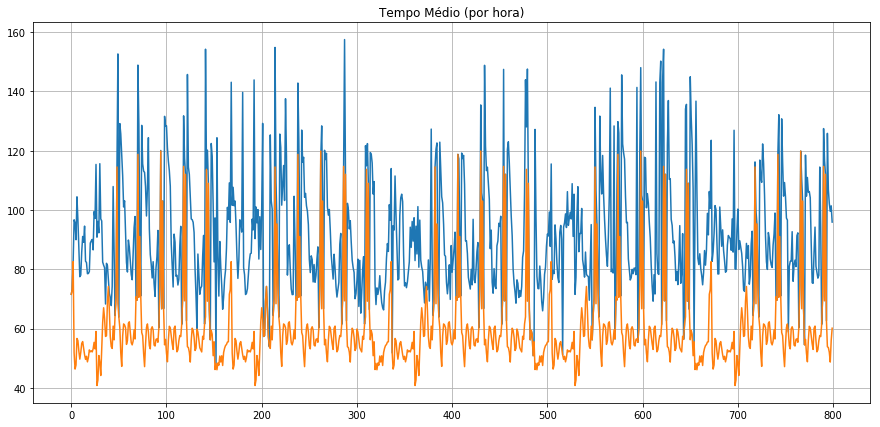

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(df['tempo_medio'][:800])
# plt.plot(df['anomalies'][:2000], "ro", markersize=4)
plt.plot(df['medianDayofweekHour'][:800])
plt.title('Tempo Médio (por hora)')
plt.grid(True)
plt.show()

In [23]:
df.tail()

,dataDayofweek,hora,tempo_medio,tipo,5_dia_util,1º dia útil,Ano Novo,Antecede feriado,Antecede feriado prolongado,Arrecadação de Convênios,...,dataDayofyear,dataIs_month_end,dataIs_month_start,dataIs_quarter_end,dataIs_quarter_start,dataIs_year_end,dataIs_year_start,dataElapsed,meanDayofweekHour,medianDayofweekHour
15704,1,19,50.8928,Normal,0,0,0,0,0,0,...,296,False,False,False,False,False,False,1540252800,75.052739,55.8203
15705,1,20,52.5700,Normal,0,0,0,0,0,0,...,296,False,False,False,False,False,False,1540252800,71.531086,59.5494
15706,1,21,49.5197,Normal,0,0,0,0,0,0,...,296,False,False,False,False,False,False,1540252800,69.418117,56.4828
15707,1,22,59.2783,Normal,0,0,0,0,0,0,...,296,False,False,False,False,False,False,1540252800,106.467967,70.7583
15708,1,23,58.2852,Normal,0,0,0,0,0,0,...,296,False,False,False,False,False,False,1540252800,94.508204,69.5561


In [24]:
df.columns

Index(['dataDayofweek', 'hora', 'tempo_medio', 'tipo', '5_dia_util',
       '1º dia útil', 'Ano Novo', 'Antecede feriado',
       'Antecede feriado prolongado', 'Arrecadação de Convênios',
       'Arrecadação de DARF e DAS', 'Arrecadação de GPS',
       'Arrecadação do Convênio IPVA', 'Ativação consulta Boleto DDA',
       'Aumento de transações CDO e ATM', 'Aumento de transações de cartões',
       'Aumento do volume de transações para os Canais Digitais e Canais Convencionais',
       'Aumento nas transações de cartões',
       'Aumento no Movimento de Compe Inferior',
       'Aumento no tempo de processamento Batch',
       'Aumento no volume de processamento do produto Poupança', 'Carnaval',
       'Congelamento do ambiente', 'Corpus Christi', 'Data comemorativa',
       'Dia Internacional do Cooperativismo', 'Dia Produção Sisbr',
       'Dia das Mães', 'Dia de Jogo do Brasil na Copa do Mundo',
       'Dia de grande movimento',
       'Dia de maior movimento do Sicoobnet Empresaria

In [12]:
tempo= [38.31444389,30.57065319,34.0685043,20.23792338,23.58628984,33.42791059,36.66667851,40.13754759,53.09476153,
        59.17723807,58.47140197,53.53683751,54.47986608,49.39372489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

In [33]:
future_df = pd.DataFrame(data=pd.date_range('00:00', periods=24, freq='H'), columns=['hora'])
future_df['tempo_medio'] = 0.0
add_datepart(future_df, 'hora', drop=True, time=True)

future_df = future_df.set_index(['horaDayofweek', 'horaHour'])
future_df['meanDayofweekHour'] = mean_col
future_df['medianDayofweekHour'] = median_col
future_df = future_df.reset_index()

In [34]:
future_df.head()

,horaDayofweek,horaHour,tempo_medio,horaYear,horaMonth,horaWeek,horaDay,horaDayofyear,horaIs_month_end,horaIs_month_start,horaIs_quarter_end,horaIs_quarter_start,horaIs_year_end,horaIs_year_start,horaMinute,horaSecond,horaElapsed,meanDayofweekHour,medianDayofweekHour
0,4,0,0.0,2018,10,43,26,299,False,False,False,False,False,False,0,0,1540512000,121.150780,114.71450
1,4,1,0.0,2018,10,43,26,299,False,False,False,False,False,False,0,0,1540515600,80.038974,69.34870
2,4,2,0.0,2018,10,43,26,299,False,False,False,False,False,False,0,0,1540519200,129.419143,112.04600
3,4,3,0.0,2018,10,43,26,299,False,False,False,False,False,False,0,0,1540522800,72.848688,62.66570
4,4,4,0.0,2018,10,43,26,299,False,False,False,False,False,False,0,0,1540526400,61.120198,53.87485


In [18]:
dep_var = 'tempo_medio'
cat_names = ['horaYear','horaMonth','horaWeek','horaDay','horaDayofweek','horaDayofyear','horaIs_month_end',
             'horaIs_month_start','horaIs_quarter_end','horaIs_quarter_start','horaIs_year_end','horaIs_year_start',
             'horaHour','horaMinute','horaSecond']

In [25]:
dep_var = 'tempo_medio'
cat_names = ['dataDayofweek', 'hora', 'tipo', 'dataYear', 'dataMonth', 'dataWeek', 'dataDay', 'dataDayofyear', 
             'dataIs_month_end', 'dataIs_month_start', 'dataIs_quarter_end', 'dataIs_quarter_start',
             'dataIs_year_end', 'dataIs_year_start']

In [ ]:
train_df = df
valid_df = future_df

In [26]:
train_df = df[:15600]
valid_df = df[15600:]

In [27]:
data = TabularDataBunch.from_df(path, train_df, valid_df, dep_var, tfms=[Categorify], cat_names=cat_names)

/opt/anaconda/anaconda3/envs/ml/lib/python3.6/site-packages/fastai/tabular/transform.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = df[n].astype('category').cat.as_ordered()
/opt/anaconda/anaconda3/envs/ml/lib/python3.6/site-packages/fastai/tabular/transform.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)


In [28]:
def get_data(data):
    cats_train,conts_train = data.train_ds.cats.numpy(), data.train_ds.conts.numpy()
    x_train = np.concatenate((cats_train,conts_train), axis=1)
    y_train = data.train_ds.y.numpy()

    cats_valid,conts_valid = data.valid_ds.cats.numpy(), data.valid_ds.conts.numpy()
    x_valid = np.concatenate((cats_valid,conts_valid), axis=1)
    y_valid = data.valid_ds.y.numpy()
    
    return x_train, y_train, x_valid, y_valid

In [29]:
x_train, y_train, x_valid, y_valid = get_data(data)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((15600, 83), (15600,), (109, 83), (109,))

In [30]:
xgb_model = xgb.XGBRegressor()
lgb_model = lgb.LGBMRegressor()
models = (xgb_model, lgb_model)

In [31]:
def train_models(x, y):
    for model in models:
        model.fit(x, y)

In [32]:
train_models(x_train, y_train)

In [33]:
xgb_pred = xgb_model.predict(x_valid)
lgb_pred = lgb_model.predict(x_valid)
blend_pred = (xgb_pred + lgb_pred) / 2

In [34]:
mean_squared_error(y_valid, xgb_pred), mean_squared_error(y_valid, lgb_pred), mean_squared_error(y_valid, blend_pred)

(183.54941, 185.59741187802194, 180.71400697023395)

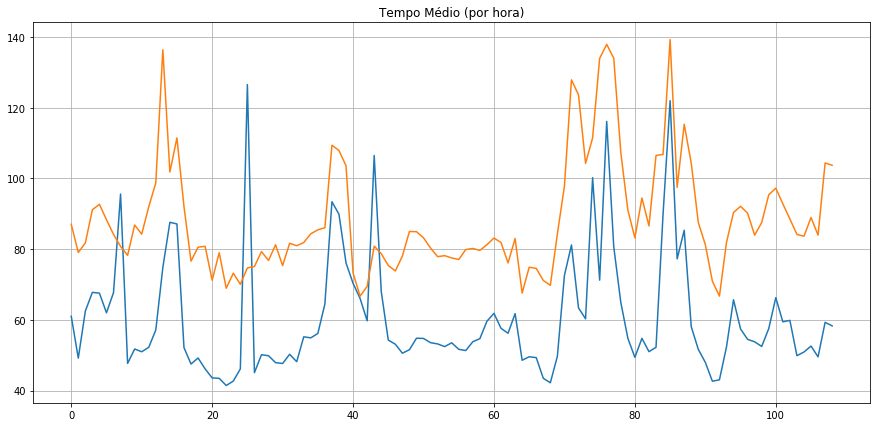

In [35]:
plt.figure(figsize=(15, 7))
plt.plot(y_valid)
plt.plot(blend_pred * 1.5)
plt.title('Tempo Médio (por hora)')
plt.grid(True)
plt.show()

In [36]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [37]:
# LightGBM parameters
lgb_params = {
    'task':'train', 
    'boosting_type':'gbdt', 
    'objective':'regression', 
    'metric': 'mae', 
    'num_leaves': 10, 
    'learning_rate': 0.02, 
    'feature_fraction': 0.8, 
    'max_depth': 5, 
    'verbose': 0, 
    'nthread':-1
}

In [38]:
print('Starting training...')
# train
gbm = lgb.train(lgb_params, lgb_train, valid_sets=[lgb_train, lgb_valid],
                num_boost_round=5000, early_stopping_rounds=50, verbose_eval=50)

Starting training...
Training until validation scores don't improve for 50 rounds.
[50]	training's l1: 11.4595	valid_1's l1: 9.76244
[100]	training's l1: 10.1812	valid_1's l1: 8.78874
[150]	training's l1: 9.63346	valid_1's l1: 8.51791
[200]	training's l1: 9.34184	valid_1's l1: 8.42722
[250]	training's l1: 9.1285	valid_1's l1: 8.39692
[300]	training's l1: 8.98076	valid_1's l1: 8.38393
[350]	training's l1: 8.86725	valid_1's l1: 8.32295
[400]	training's l1: 8.7754	valid_1's l1: 8.27524
Early stopping, best iteration is:
[389]	training's l1: 8.79507	valid_1's l1: 8.265


In [39]:
print('Starting predicting...')
# predict
lgb_pred = gbm.predict(x_valid, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_valid, lgb_pred))

Starting predicting...
The rmse of prediction is: 185.06658407806756


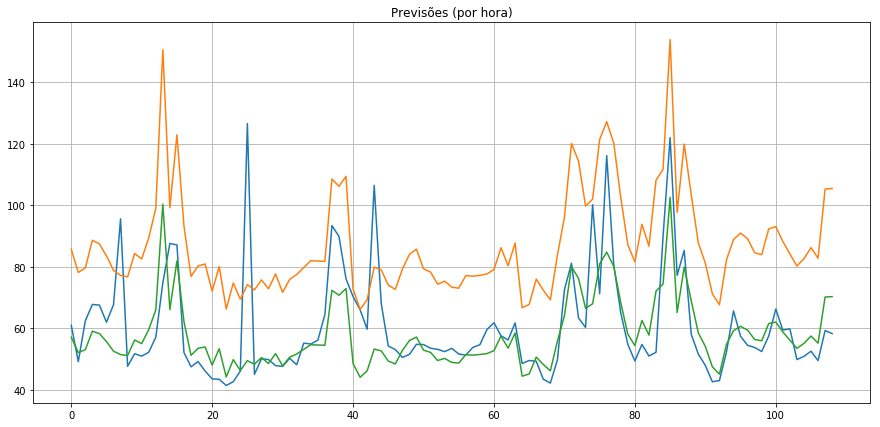

In [40]:
plt.figure(figsize=(15, 7))
plt.plot(valid_df.reset_index().tempo_medio)
plt.plot(lgb_pred * 1.5)
plt.plot(lgb_pred)
plt.title('Previsões (por hora)')
plt.grid(True)
plt.show()

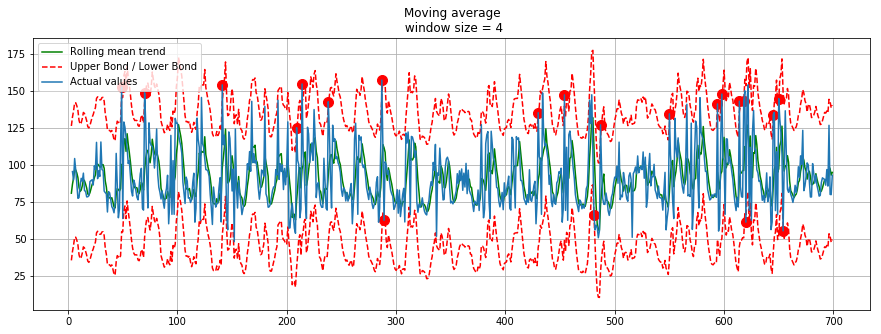

In [197]:
plotMovingAverage(df[['tempo_medio']][:700], 4, plot_intervals=True, plot_anomalies=True)

In [136]:
df[['hora','tempo_medio']].head()

,hora,tempo_medio
0,2017-01-01 00:00:00,353.5510
1,2017-01-01 01:00:00,317.1040
2,2017-01-01 02:00:00,423.2300
3,2017-01-01 03:00:00,96.7003
4,2017-01-01 04:00:00,95.6170


In [133]:
df.loc[df['tempo_medio'] > 800.0, 'tempo_medio']

Series([], Name: tempo_medio, dtype: float64)

In [20]:
teste = df[['hora','tempo_medio']].set_index('hora')

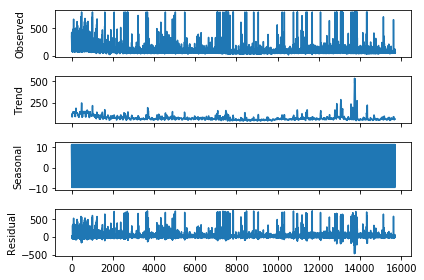

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = df['tempo_medio']
result = seasonal_decompose(series, model='additive', freq = 24)
result.plot()
pyplot.show()

In [46]:
running_median = running_median_insort(df['tempo_medio'], 12)

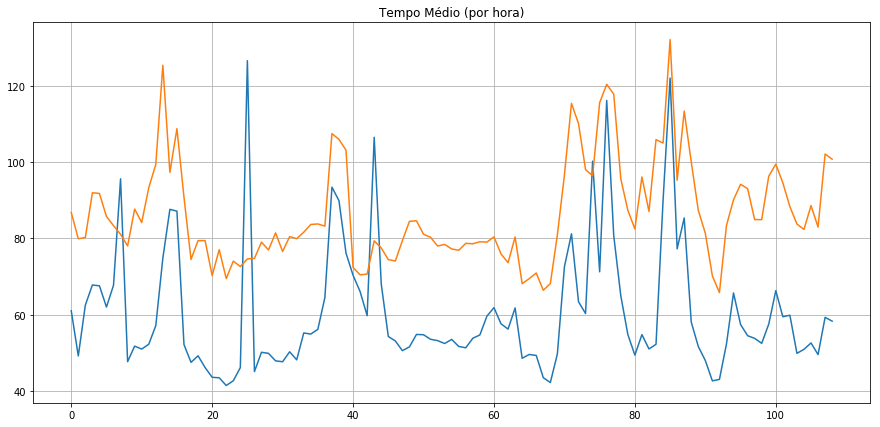

In [214]:
plt.figure(figsize=(15, 7))
plt.plot(y_valid)
plt.plot(blend_pred * 1.5)

# plt.plot(running_median[2000:3000])
# plt.plot(df['medianDayofweekHour'][2000:3000])
# plt.plot(df_teste['tempo_medio_median'][2000:3000])
plt.title('Tempo Médio (por hora)')
plt.grid(True)
plt.show()

NameError: name 'df_teste' is not defined

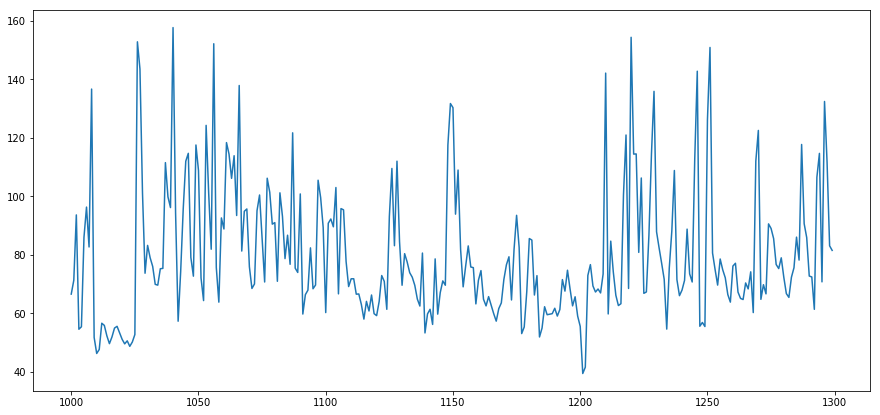

In [43]:
plt.figure(figsize=(15, 7))
plt.plot(df['tempo_medio'][1000:1300])
# plt.plot(running_median[:1000])
# plt.plot(df['medianDayofweekHour'][:1000])
plt.plot(df_teste['tempo_medio_median'][1000:1300])
plt.plot(df['anomalies'][1000:1300], "ro", markersize=4)
plt.title('Tempo Médio (por hora)')
plt.grid(True)
plt.show()

In [ ]:
df.groupby(['horaDayofweek', 'horaHour'])['tempo_medio'].rolling(3).median()

In [86]:
df_teste = df.assign(tempo_medio_median=df.groupby(['horaDayofweek', 'horaHour'], as_index=False)[['tempo_medio']]
                           .rolling(4, min_periods=0).median().fillna(0)
                           .reset_index(0, drop=True))

In [92]:
df['rolling_median'] = df.groupby(['horaDayofweek', 'horaHour'])['tempo_medio'].apply(lambda x: x.rolling(3, min_periods=1, center=True).median())

In [93]:
df.head()

,horaDayofweek,horaHour,tempo_medio,horaYear,horaMonth,horaWeek,horaDay,horaDayofyear,horaIs_month_end,horaIs_month_start,horaIs_quarter_end,horaIs_quarter_start,horaIs_year_end,horaIs_year_start,horaMinute,horaSecond,horaElapsed,meanDayofweekHour,medianDayofweekHour,rolling_median
0,6,0,71.5714,2017,1,52,1,1,False,True,False,True,False,True,0,0,1483228800,96.711609,71.57140,90.35820
1,6,1,73.1916,2017,1,52,1,1,False,True,False,True,False,True,0,0,1483232400,115.975351,73.19160,84.50620
2,6,2,82.5933,2017,1,52,1,1,False,True,False,True,False,True,0,0,1483236000,119.638727,82.59330,112.85115
3,6,3,96.7003,2017,1,52,1,1,False,True,False,True,False,True,0,0,1483239600,74.728029,51.80675,99.14915
4,6,4,95.6170,2017,1,52,1,1,False,True,False,True,False,True,0,0,1483243200,73.957546,46.33060,101.63900


In [68]:
df_teste.tail()

,horaDayofweek,horaHour,tempo_medio,horaYear,horaMonth,horaWeek,horaDay,horaDayofyear,horaIs_month_end,horaIs_month_start,horaIs_quarter_end,horaIs_quarter_start,horaIs_year_end,horaIs_year_start,horaMinute,horaSecond,horaElapsed,meanDayofweekHour,medianDayofweekHour,tempo_medio_median
15704,1,19,50.8928,2018,10,43,23,296,False,False,False,False,False,False,0,0,1540321200,75.052739,55.8203,48.9633
15705,1,20,52.5700,2018,10,43,23,296,False,False,False,False,False,False,0,0,1540324800,71.531086,59.5494,52.7203
15706,1,21,49.5197,2018,10,43,23,296,False,False,False,False,False,False,0,0,1540328400,69.418117,56.4828,50.5365
15707,1,22,59.2783,2018,10,43,23,296,False,False,False,False,False,False,0,0,1540332000,106.467967,70.7583,63.9883
15708,1,23,58.2852,2018,10,43,23,296,False,False,False,False,False,False,0,0,1540335600,94.508204,69.5561,59.7087


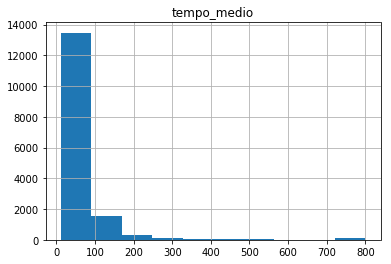

In [93]:
hist = df[['tempo_medio']].hist(bins=10)

In [97]:
df['tempo_medio'].median(), df['tempo_medio'].std()

(57.1729, 83.0168407571287)

In [207]:
z_score, outlier = is_outlier(df['tempo_medio'], thresh=3.5)

In [208]:
unique, counts = np.unique(outlier, return_counts=True)
dict(zip(unique, counts))

{False: 14609, True: 1100}

In [209]:
df['anomalies'] = df[outlier]['tempo_medio']

In [ ]:
df.loc[df['tempo_medio'] > 800.0, 'tempo_medio'] = 800.0

In [ ]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb_model.tr
# make prediction
preds = bst.predict(dtest)

In [81]:
valid_df.loc[valid_df['horaHour'] < 6, 'teste'] = 1

In [ ]:
df.at[outlier, 'tempo_medio'] = df[outlier]['medianDayofweekHour']

In [82]:
valid_df.head()

,horaDayofweek,horaHour,tempo_medio,horaYear,horaMonth,horaWeek,horaDay,horaDayofyear,horaIs_month_end,horaIs_month_start,horaIs_quarter_end,horaIs_quarter_start,horaIs_year_end,horaIs_year_start,horaMinute,horaSecond,horaElapsed,meanDayofweekHour,medianDayofweekHour,teste
15600,4,11,61.0035,2018,10,42,19,292,False,False,False,False,False,False,0,0,1539946800,74.672213,57.06350,NaN
15601,4,12,49.1636,2018,10,42,19,292,False,False,False,False,False,False,0,0,1539950400,67.124501,52.59760,NaN
15602,4,13,62.4715,2018,10,42,19,292,False,False,False,False,False,False,0,0,1539954000,72.272869,53.34920,NaN
15603,4,14,67.7618,2018,10,42,19,292,False,False,False,False,False,False,0,0,1539957600,92.772701,59.85390,NaN
15604,4,15,67.5407,2018,10,42,19,292,False,False,False,False,False,False,0,0,1539961200,70.371570,58.83595,NaN


In [17]:
df_mapa = get_mapa_de_eventos()

In [47]:
df.data = df.data.astype(str)
df_mapa.data = df_mapa.data.astype(str)
df = df.merge(df_mapa, on='data', how='left')

In [43]:
df_mapa.data = df_mapa.data.astype(str)

In [48]:
df.head()

,data,hora,tempo_medio,tipo,5_dia_util,1º dia útil,Ano Novo,Antecede feriado,Antecede feriado prolongado,Arrecadação de Convênios,...,Provável dia de Jogo do Brasil na Copa do Mundo,Páscoa,Pós data comemorativa,Pós feriado,Pós feriado prolongado,Tiradentes,Transações de compe Inferior,Utilização de Caixa Eletrônico,Utilização dos Canais Digitais,Utilização dos aplicativos #ContaFácil e #FaçaParte
0,2017-01-01,0,353.5510,Feriado,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2017-01-01,1,317.1040,Feriado,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2017-01-01,2,423.2300,Feriado,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2017-01-01,3,96.7003,Feriado,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2017-01-01,4,95.6170,Feriado,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df.set_index('data').join(df_mapa.set_index('data'), how='left').reset_index()